# Adaptive Boosting (adaBoost)

In this notebook, we present the Adaptive Boosting (AdaBoost) algorithm. The aim is to get intuitions regarding the internal machinery of AdaBoost and boosting in general.  

We will load the 'penguin' dataset. We will predict penguin species from the culmen length and depth features

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
penguins = pd.read_csv('data/penguins_classification.csv')
penguins.sample(5)

,Culmen Length (mm),Culmen Depth (mm),Species
175,42.9,13.1,Gentoo
40,40.8,18.4,Adelie
153,48.7,14.1,Gentoo
170,48.7,15.1,Gentoo
245,44.5,14.7,Gentoo


In [7]:
culmen_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_column = "Species"

data, target = penguins[culmen_columns], penguins[target_column]
range_features = {
    feature_name: (data[feature_name].min() - 1, data[feature_name].max() + 1)
    for feature_name in data.columns}

In addition, we are also using the function used in the previous notebook to plot the decision function of the tree

In [8]:
def plot_decision_function(fitted_classifier, range_features, ax=None):
    """Plot the boundary of the decision function of a classifier."""
    from sklearn.preprocessing import LabelEncoder

    feature_names = list(range_features.keys())
    # create a grid to evaluate all possible samples
    plot_step = 0.02
    xx, yy = np.meshgrid(
        np.arange(*range_features[feature_names[0]], plot_step),
        np.arange(*range_features[feature_names[1]], plot_step),
    )

    # compute the associated prediction
    Z = fitted_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = LabelEncoder().fit_transform(Z)
    Z = Z.reshape(xx.shape)

    # make the plot of the boundary and the data samples
    if ax is None:
        _, ax = plt.subplots()
    ax.contourf(xx, yy, Z, alpha=0.4, cmap="RdBu")

    return ax

We will purposefully train a shallow decision tree. Since it is shallow, it is unlikely to overfit and some of the training examples will even be misclassified

In [9]:
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

palette = ['tab:red', 'tab:blue', 'black']
tree = DecisionTreeClassifier(max_depth=2, random_state=0)
tree.fit(data, target)

DecisionTreeClassifier(max_depth=2, random_state=0)

In [11]:
target_predicted = tree.predict(data)
misclassified_samples_idx = np.flatnonzero(target != target_predicted)
data_misclassified = data.iloc[misclassified_samples_idx]

/Users/athena/opt/miniconda3/envs/work/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


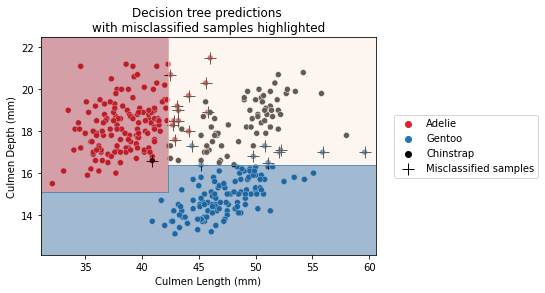

In [12]:
# plot the original dataset
sns.scatterplot(data=penguins, x=culmen_columns[0], y=culmen_columns[1],
                hue=target_column, palette=palette)
# plot the misclassified samples
ax = sns.scatterplot(data=data_misclassified, x=culmen_columns[0],
                     y=culmen_columns[1], label="Misclassified samples",
                     marker="+", s=150, color="k")
plot_decision_function(tree, range_features, ax=ax)

plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
_ = plt.title("Decision tree predictions \nwith misclassified samples "
              "highlighted")

We observe that several samples have been misclassified by the classifier.  

We mentioned that boosting relies on creating a new classifier which tries to correct these misclassifications. In scikit-learn, learners have a parameter `sample_weight` which forces it to pay more attention to samples with higher weights during the training.  

This parameter is set when calling `classifier.fit(X, y, sample_weight=weights)`. We will use this trick to create a new classifier by `discarding` all correctly classified samples and only considering the misclassifed samples